In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [2]:

outDir = os.path.join('output')
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)


EPOCHS =1001 # nos of epochs
ALPHA = 0.001 # learning 
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
         }
CMAP = 'coolwarm'
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

plt .rcParams.update(params)

<Figure size 1500x800 with 0 Axes>

### Prevent Tensorflow from hogging the memory

In [3]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [7]:
train_df.shape , test_df.shape

((60000, 785), (10000, 785))

In [8]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [9]:
test_df['label'].unique()

array([0, 1, 2, 3, 8, 6, 5, 4, 7, 9], dtype=int64)

In [10]:
train_df.max()

label         9
pixel1       16
pixel2       36
pixel3      226
pixel4      164
           ... 
pixel780    255
pixel781    255
pixel782    255
pixel783    255
pixel784    170
Length: 785, dtype: int64

In [11]:
train_df.min()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

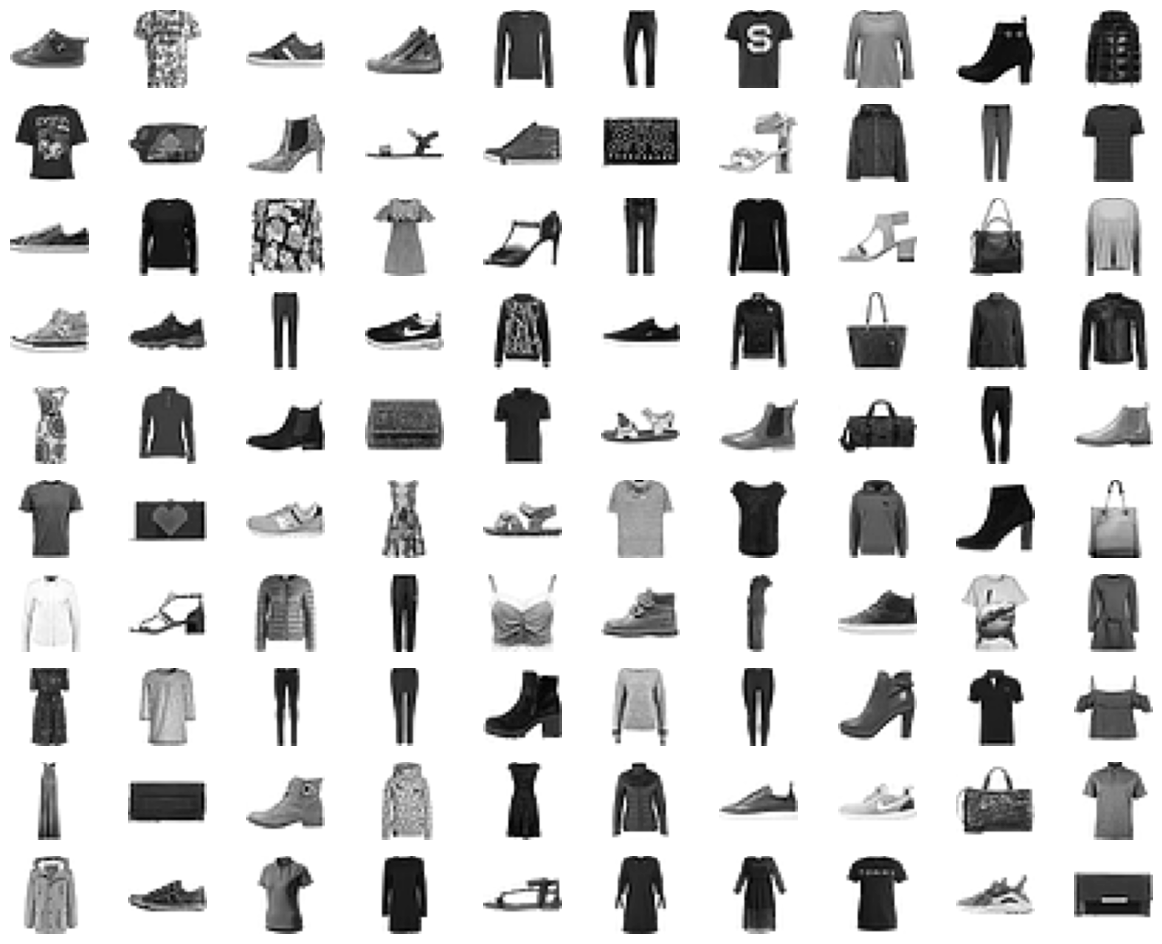

In [12]:
plot_df = train_df.sample(n = 100) # sample 100
fig = plt.figure(figsize = (15,12))
i = 0
for _, row in plot_df.iterrows():
    i += 1

    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(10,10,(i),xticks=[],yticks=[])

    ax.imshow(image, cmap=plt.cm.binary)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [14]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
features_df = train_df.drop('label',axis =1)
labels =train_df['label']

In [16]:
labels.value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

In [17]:
labels = pd.get_dummies(labels)

In [18]:
X_train, X_test, y_train,y_test = train_test_split(features_df,labels,
                                                   test_size=TEST_SIZE, 
                                                   stratify=labels, 
                                                   random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape,y_test.shape 

((48000, 784), (12000, 784), (48000, 10), (12000, 10))

In [19]:
cols = train_df.columns

for col in cols:
    print(f'\nColumns Name: {col} : {train_df[col].unique()}')


Columns Name: label : [2 9 6 0 3 4 5 8 7 1]

Columns Name: pixel1 : [ 0 14  7  3 16  1  4  2]

Columns Name: pixel2 : [ 0  1  3 10  6  2  7  5 16 14 13  9 34 15  4 11 36]

Columns Name: pixel3 : [  0   2   1  10   3   6   4   5   7  56  34  32  16  14  78  25  13   9
   8  52  35  30  23  54 226  15 106]

Columns Name: pixel4 : [  0   1   5   2   3  20  46  87   4  16  12   6  64  36  52  13   7 164
 110  14  92 106 120 105  53  70   9  23  49  25  26  34 121  21  17  10
  41  18  28  80  56 144  22  54  55  50  90 150  19 109  83 132  48  11
  32 145  39  96  15  58   8  68  82 146  86]

Columns Name: pixel5 : [  0   2   4   1   5   3  26  14  39  62  15  16  84   7  88  41  65  17
  35  61  11  21  10   6  18 119 162 106  34  12 217  33  24  37  13 185
  38  71  73   9  40  56  68 171  89  97  91  23  59  42  77 103  29 148
 140  31  45 201   8  95 133  80  44  43  27  20  32  58 123  22 116  66
  60  53 145  85 100  54 210 166 113  19  28 227  30  51  64  96  75  70
  90  82 115 15

In [20]:
sc  = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
torch.cuda.current_device()

0

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [24]:
input_dim = X_train.shape[1] # number of cols in features

model = nn.Sequential(nn.Linear(input_dim,397),
                      nn.Tanh(),
                      nn.Linear(397,10))
                     
model = model.to(device)

In [25]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=397, bias=True)
  (1): Tanh()
  (2): Linear(in_features=397, out_features=10, bias=True)
)


In [26]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0115,  0.0174, -0.0135,  ...,  0.0071, -0.0240,  0.0344],
         [-0.0120,  0.0287,  0.0235,  ...,  0.0151, -0.0105, -0.0155],
         [-0.0132, -0.0238, -0.0210,  ..., -0.0335, -0.0188, -0.0254],
         ...,
         [ 0.0035, -0.0299,  0.0256,  ..., -0.0285,  0.0070, -0.0204],
         [ 0.0080, -0.0125,  0.0181,  ...,  0.0269, -0.0099,  0.0081],
         [-0.0088,  0.0232, -0.0275,  ...,  0.0024,  0.0149, -0.0254]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0334,  0.0007,  0.0150,  0.0332,  0.0014,  0.0226,  0.0184,  0.0270,
          0.0067, -0.0045,  0.0345,  0.0302,  0.0100, -0.0274, -0.0117,  0.0008,
          0.0237,  0.0174, -0.0065,  0.0320, -0.0168,  0.0233,  0.0036,  0.0016,
         -0.0290, -0.0291, -0.0276,  0.0104, -0.0346, -0.0048, -0.0102,  0.0047,
          0.0205,  0.0099, -0.0249, -0.0175,  0.0094,  0.0330, -0.0308,  0.0316,
         -0.0270,  0.0165,  0.0075,  0.0115,  0.0294, -0.0284,

In [27]:
print(f'Number of parameter: {len(list(model.parameters()))}')

Number of parameter: 4


In [28]:
print(f'Layer 1 Weights: {list(model.parameters())[0].shape}')
print(f'Layer 1 bias   : {list(model.parameters())[1].shape}')
print(f'Layer 2 Weights: {list(model.parameters())[2].shape}')
print(f'Layer 2 bias   : {list(model.parameters())[3].shape}')

Layer 1 Weights: torch.Size([397, 784])
Layer 1 bias   : torch.Size([397])
Layer 2 Weights: torch.Size([10, 397])
Layer 2 bias   : torch.Size([10])


In [29]:
train_X = Variable(torch.Tensor(X_train)).to(device)
test_X = Variable(torch.Tensor(X_test)).to(device)
train_y = Variable(torch.Tensor(y_train.to_numpy())).to(device)
test_y = Variable(torch.Tensor(y_test.to_numpy())).to(device)

In [30]:
# predict.shape,train_y.shape

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = ALPHA,weight_decay=1e-5)  # regularization parameter


loss, tloss, n_epoch, acc, tacc= [],[],[],[],[]

for epoch in range(EPOCHS):
    model.train() # set ur model in train mode
    
    predict = model(train_X) # make prediction

    curr_loss = loss_fn(predict,train_y) # calculate loss
    
   ########################## 
   ### Back Propagation #####
   ##########################
    optimizer.zero_grad()
    curr_loss.backward()
    optimizer.step()
    
    loss.append(curr_loss.data.item())
    
    _, y_pred = torch.max(predict, 1)
    
    curr_acc = accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())
    
    acc.append(curr_acc)
    
    model.eval() # dont update weights
    
    predict_tst = model(test_X) # MAKE PREDICTION
    
    curr_loss_tst = loss_fn(predict_tst, test_y)  # Calculate loss
    
    tloss.append(curr_loss_tst.data.item())
    
    _, y_pred = torch.max(predict, 1)
    
    curr_acc_tst = accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())

    tacc.append(curr_acc_tst)
    
    n_epoch.append(epoch)

In [32]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss': loss,
                       'test loss' : tloss,
                       'acc':acc,
                       'test acc': tacc
                       })
loss_df.head()

,epoch,loss,test loss,acc,test acc
0,0,2.272611,1.489982,0.175187,0.175187
1,1,1.483077,1.150728,0.614313,0.614313
2,2,1.140359,0.988686,0.652667,0.652667
3,3,0.977153,0.888175,0.677771,0.677771
4,4,0.876280,0.817665,0.701500,0.701500


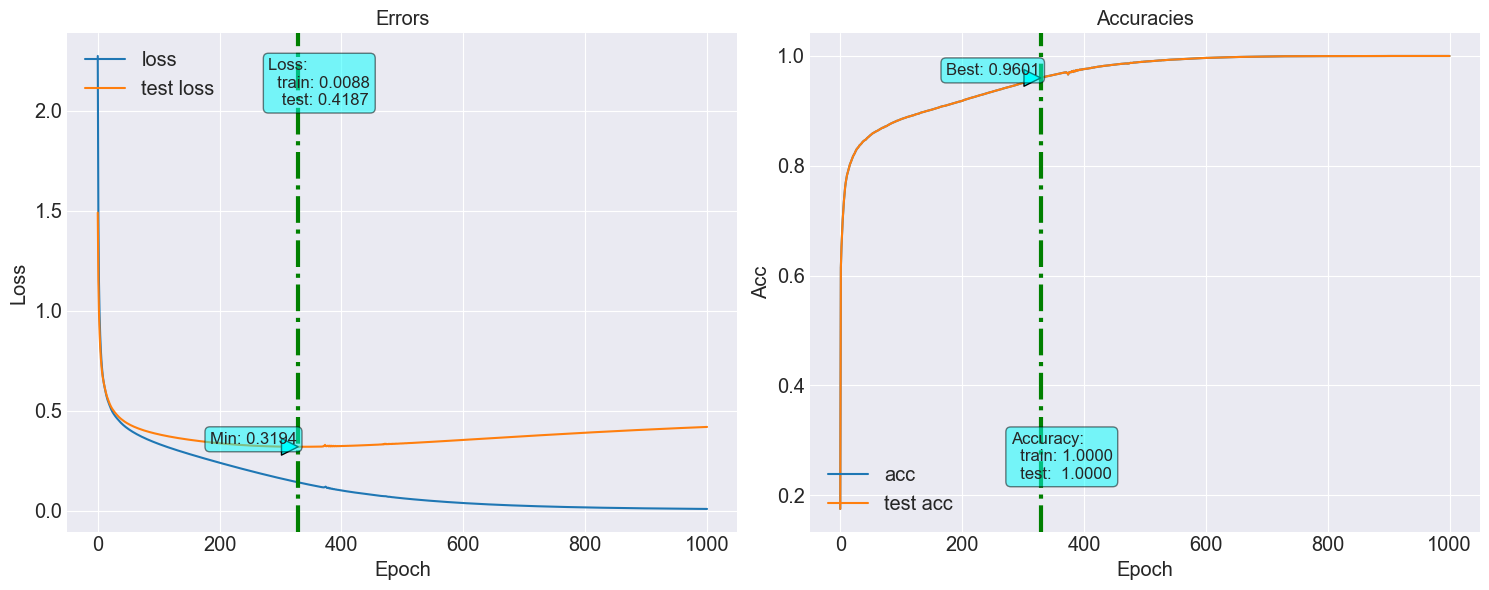

In [33]:
fn_plot_torch_hist(loss_df)

In [34]:
predict = model(train_X)

_, y_pred = torch.max(predict, 1)

accuracy_score(y_train.to_numpy().argmax(axis=1),y_pred.data.cpu())


1.0

In [35]:
predict = model(test_X)

_, y_pred = torch.max(predict, 1)

accuracy_score(y_test.to_numpy().argmax(axis=1),y_pred.data.cpu())

0.893